In [1]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_path=os.getcwd()+'\\data'
df=pd.read_csv(data_path+'\\kdd99.csv', sep=';')
print(df.shape)

(346016, 46)


In [3]:
print(df.head())

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_diff_host_rate  \
0               0       0    0  ...                            0   
1               0       0    0  ...                            0   
2               0       0    0  ...                            0   
3               0       0    0  ...                            0   
4               0       0    0  ...                            0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                     0                         0                     0   
1                   

In [4]:
df['Attack_Type'].value_counts()

dos       267327
normal     74033
probe       3499
r2l         1125
u2r           32
Name: Attack_Type, dtype: int64

In [5]:
print(df.dtypes)

duration                        int64
protocol_type                  object
service                        object
flag                           object
src_bytes                       int64
dst_bytes                       int64
land                            int64
wrong_fragment                  int64
urgent                          int64
hot                             int64
num_failed_logins               int64
logged_in                       int64
num_compromised                 int64
root_shell                      int64
su_attempted                    int64
num_root                        int64
num_file_creations              int64
num_shells                      int64
num_access_files                int64
num_outbound_cmds               int64
is_host_login                   int64
is_guest_login                  int64
count                           int64
srv_count                       int64
serror_rate                     int64
srv_serror_rate                 int64
rerror_rate 

In [6]:
print('Data types before transformation')
print(df.dtypes)
pmap = {'icmp':0,'tcp':1,'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 
,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)
df.drop('service',axis = 1,inplace= True)
df.drop(['target',], axis=1, inplace= True)
df = df.dropna('columns')
df = df[[col for col in df if df[col].nunique() > 1]]
print('Data types after transformation')
print(df.dtypes)

Data types before transformation
duration                        int64
protocol_type                  object
service                        object
flag                           object
src_bytes                       int64
dst_bytes                       int64
land                            int64
wrong_fragment                  int64
urgent                          int64
hot                             int64
num_failed_logins               int64
logged_in                       int64
num_compromised                 int64
root_shell                      int64
su_attempted                    int64
num_root                        int64
num_file_creations              int64
num_shells                      int64
num_access_files                int64
num_outbound_cmds               int64
is_host_login                   int64
is_guest_login                  int64
count                           int64
srv_count                       int64
serror_rate                     int64
srv_serror_rate  

C:\Users\Arnau\AppData\Local\Temp\ipykernel_23912\3671355948.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


Data types after transformation
duration                        int64
protocol_type                   int64
flag                            int64
src_bytes                       int64
dst_bytes                       int64
land                            int64
wrong_fragment                  int64
urgent                          int64
hot                             int64
num_failed_logins               int64
logged_in                       int64
num_compromised                 int64
root_shell                      int64
su_attempted                    int64
num_root                        int64
num_file_creations              int64
num_shells                      int64
num_access_files                int64
is_guest_login                  int64
count                           int64
srv_count                       int64
serror_rate                     int64
srv_serror_rate                 int64
rerror_rate                     int64
srv_rerror_rate                 int64
same_srv_rate     

C:\Users\Arnau\AppData\Local\Temp\ipykernel_23912\904150308.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


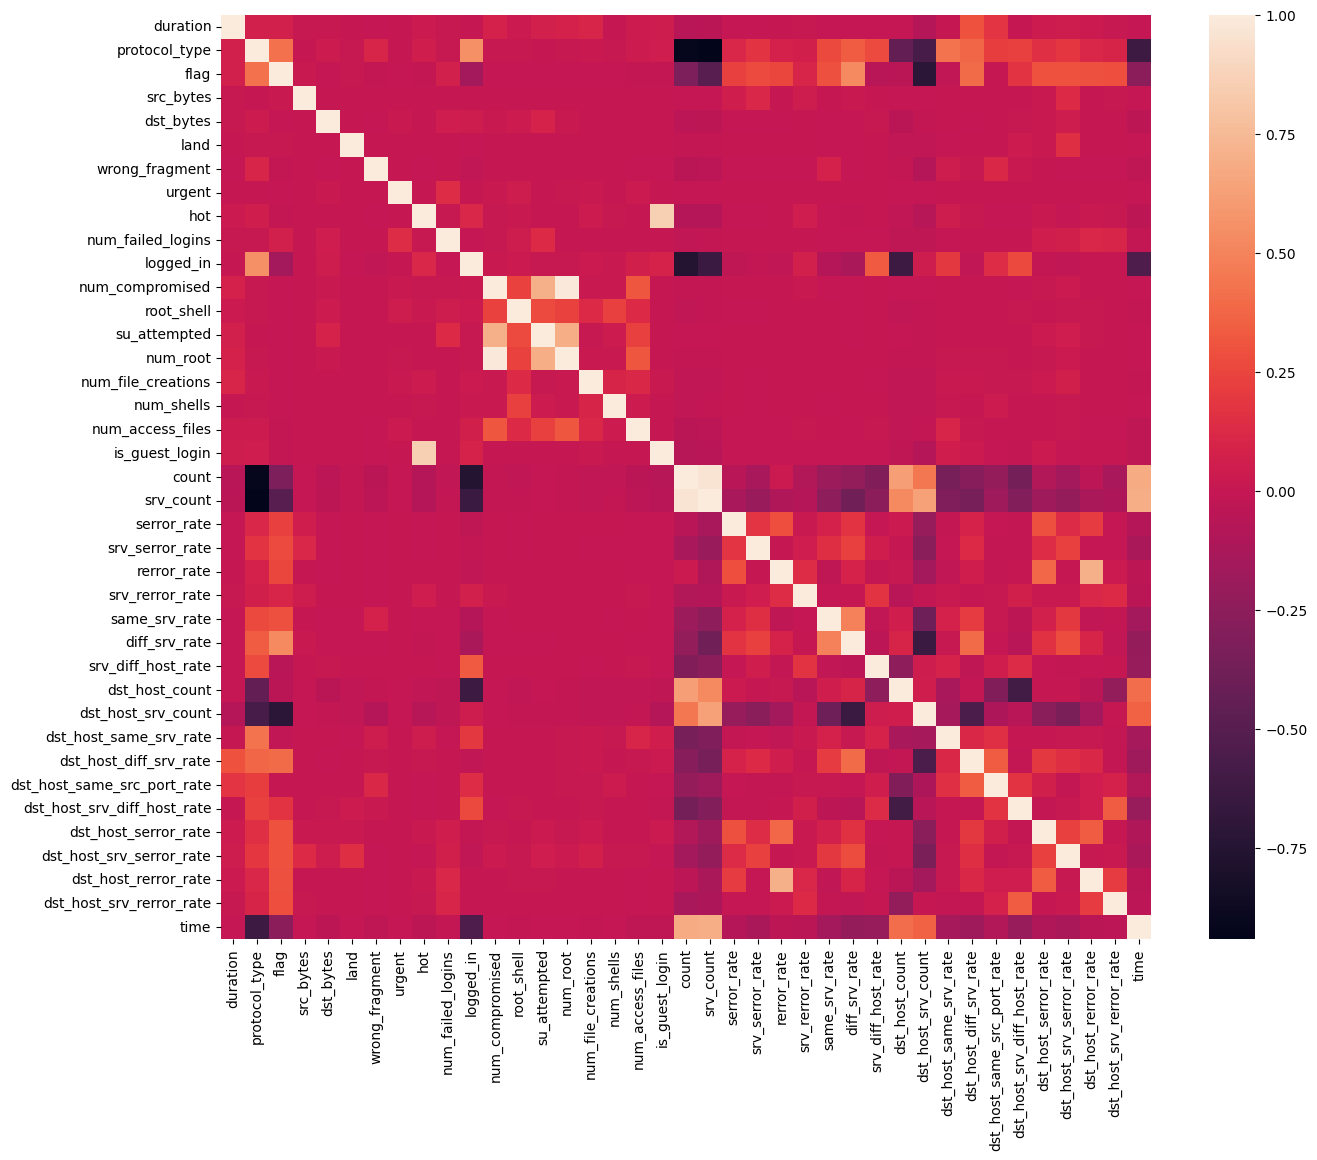

In [7]:
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

In [8]:
cor_thr=0.98
print('Shape before feature reduction: ', df.shape)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > cor_thr)]
print('Features to drop')
print(to_drop)
for i in to_drop:
    df.drop(i,axis = 1,inplace = True)
print('Shape after feature reduction: ', df.shape)

Shape before feature reduction:  (346016, 40)


C:\Users\Arnau\AppData\Local\Temp\ipykernel_23912\3282369649.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


Features to drop
['num_root']
Shape after feature reduction:  (346016, 39)


C:\Users\Arnau\AppData\Local\Temp\ipykernel_23912\3282369649.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [9]:
# Define column name of the label vector
LABEL = "Attack_Type_Encoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["Attack_Type"].values.ravel())
print(df.head())

   duration  protocol_type  flag  src_bytes  dst_bytes  land  wrong_fragment  \
0         0              1     0        181       5450     0               0   
1         0              1     0        239        486     0               0   
2         0              1     0        235       1337     0               0   
3         0              1     0        219       1337     0               0   
4         0              1     0        217       2032     0               0   

   urgent  hot  num_failed_logins  ...  dst_host_diff_srv_rate  \
0       0    0                  0  ...                       0   
1       0    0                  0  ...                       0   
2       0    0                  0  ...                       0   
3       0    0                  0  ...                       0   
4       0    0                  0  ...                       0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                           11                            0

In [10]:
# Target variable and train set
Y = df[[LABEL]]
X = df.drop([LABEL,'Attack_Type',], axis=1)

sc = MinMaxScaler()
X = sc.fit_transform(X)

# Split test and train data 
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, stratify=Y)
print(X_train.shape, X_validation.shape)
print(Y_train.shape, Y_validation.shape)

(276812, 38) (69204, 38)
(276812, 1) (69204, 1)


In [11]:
callback = EarlyStopping(monitor='acc', patience=1)

X_train = np.reshape(X_train, (1, X_train.shape[0], X_train.shape[1]))
X_validation = np.reshape(X_validation, (1, X_validation.shape[0], X_validation.shape[1]))
print('Shape after reshape X_train:', X_train.shape)
print('Shape after reshape X_validation:', X_validation.shape)

Y_train = np_utils.to_categorical(Y_train, 5)
Y_validation = np_utils.to_categorical(Y_validation, 5)
print('New Y_train shape: ', Y_train.shape)
print('New Y_validation shape: ', Y_validation.shape)

# Formato actual:
    # INPUT: (1, 200k, 38)  --> 1 segmento de 200k rows por 38 features.
    # OUTPUT: (200k, 5) --> 200k resultados, 1 por cada segmento, de 5 labels con sus porcentajes.
# Problema: y_train tiene que mostrar un resultado en formato (1, 5) 1 row con 5 porcentajes de resultado para cada segmento
# Implicación: y_train es el resultado para todo el segmento. En este caso segmento=1=todo dataset. --> INCORRECTO
# Replanteamiento:
    # formato (200k, 1, 38) --> cada row del dataset es 1 segmento de 1 row con 38 features.
    # y_train mostrarà formato (1, 5) 1 solo resultado para 1 segmento de 1 row.
    # Problema:
        # un modelo con layers que parten de un input = 1 no se puede modelar debido a la falta de dowsampling
# Solucion:
    # FLOW AGREGATION = Segmento --> 1 mismo resultado para todo el segmento
    # formato entrada (segmentos, flows, 38)

model_odcnn = Sequential()
model_odcnn.add(Conv1D(filters=100, kernel_size=10, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],)))
model_odcnn.add(Conv1D(filters=100, kernel_size=10, activation='relu'))
model_odcnn.add(MaxPooling1D(3))   #---> output matrix després de maxpooling es 1/3 de input matrix
model_odcnn.add(Conv1D(160, 10, activation='relu'))
model_odcnn.add(Conv1D(160, 10, activation='relu'))
model_odcnn.add(GlobalAveragePooling1D())    #---> agafa nomes 1 weight de mitja
model_odcnn.add(Dropout(0.5))    #---> 50% random de les neurones rebran un weight=0
model_odcnn.add(Dense(5, activation='softmax'))   # ---> reduir les 160 prediccions a la probabilitat corresponent entre les labels que tenim
print(model_odcnn.summary())


model_odcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_odcnn.fit(X_train,
                      Y_train,
                      batch_size=400,
                      epochs=50,
                      callbacks=[callback],
                      validation_data=(X_validation,Y_validation),
                      verbose=1)

history_dict = history.history
history_dict.keys()

Shape after reshape X_train: (1, 276812, 38)
Shape after reshape X_validation: (1, 69204, 38)
New Y_train shape:  (276812, 5)
New Y_validation shape:  (69204, 5)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 276803, 100)       38100     
                                                                 
 conv1d_1 (Conv1D)           (None, 276794, 100)       100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92264, 100)       0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 92255, 160)        160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 92246, 160)        256160    
                          

ValueError: Data cardinality is ambiguous:
  x sizes: 1
  y sizes: 276812
Make sure all arrays contain the same number of samples.

In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']

print(loss)
print(accuracy)
    
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1, 2, 1)
plt.plot(range(0, 50), loss, 'bo', label='Training loss', color='red')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, 50), accuracy, 'bo', label='Training acc', color='red')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score
# def plot_confusion_matrix(Y_real, Y_pred, title=None):
#     labels=np.unique(Y_real)
#     nc=len(labels)
#     data=np.zeros((nc,nc))
#     pairs=zip(Y_real,Y_pred)
#     pairs=list(pairs)
#     for p in pairs: data[np.where(labels==p[0]),np.where(labels==p[1])]+=1
#     row_total=np.sum(data,axis=1)
#     data=data/row_total.reshape((nc,1))
#     sns.set(color_codes=True)
#     plt.figure(1, figsize=(9, 6))
#     plt.title('Confusion Matrix') if title is None else plt.title(title)
#     sns.set(font_scale=1.4)
#     ax = sns.heatmap(data, annot=True, cmap='Blues', cbar_kws={'label': 'Scale'})
#     ax.set_xticklabels(labels)
#     ax.set_yticklabels(labels)
#     ax.set(ylabel='True Label', xlabel='Predicted Label')
#     plt.show()
#     
#   
# print('ANN evaluation')
# start_time = time.time()
# Y_train_pred=model_ann.predict(X_train)
# Y_validation_pred=model_ann.predict(X_validation)
# time_eval_ann=time.time()-start_time
# 
# print('Overall accuracy training: ', accuracy_score(Y_train,Y_train_pred))
# print('Overall accuracy validation: ', accuracy_score(Y_validation,Y_validation_pred))
# 
# print('Training time (seconds per sample): ', time_train_ann/float(Y_train.shape[0]))
# print('Evaluation time (seconds per sample): ', 
# time_eval_ann/(float(Y_train.shape[0])+float(Y_validation.shape[0])))
# 
# plot_confusion_matrix(Y_train.values.ravel(),Y_train_pred, title='ANN - Training')
# plot_confusion_matrix(Y_validation.values.ravel(),Y_validation_pred, title='ANN - Testing')
    
